In [1]:
import carla
import numpy as np
import matplotlib.pyplot as plt
import json
from agents.navigation.global_route_planner import GlobalRoutePlanner
from scipy.optimize import minimize

# For estimating the parameters for the kinematic bicycle model we used a script like this one.
# Unfortunately, we could not find the original one, that produced the used parameters anymore.
# Hence, we reproduced it here. Although, the proposed parameters are a little different, they are quite close.
# Nevertheless, e also evaluated on these parameters and they work equally well.

In [2]:
def load_dict(pth):
    with open(pth, 'r') as fp:
        d = json.load(fp)
        d['ego_locations'] = np.array(d['ego_locations'])
        d['ego_controls'] = np.array(d['ego_controls'])
        d['ego_rotations'] = np.array(d['ego_rotations'])
        d['ego_speeds'] = np.array(d['ego_speeds'])
        
        map_locations = np.array(d['map_locations'])
        del d['map_locations']
        
        return d, map_locations

In [3]:
data = []
map_locations = None
for pth in ['throttle_1.0.json', 'throttle_0.9.json', 'throttle_0.8.json', 'throttle_0.7.json', 'throttle_0.6.json', 'throttle_0.5.json']:
    d, map_locations = load_dict(pth)
    throttle = float(pth.replace('.json', '').split('_')[1])
    d['throttle'] = throttle
    data.append(d)

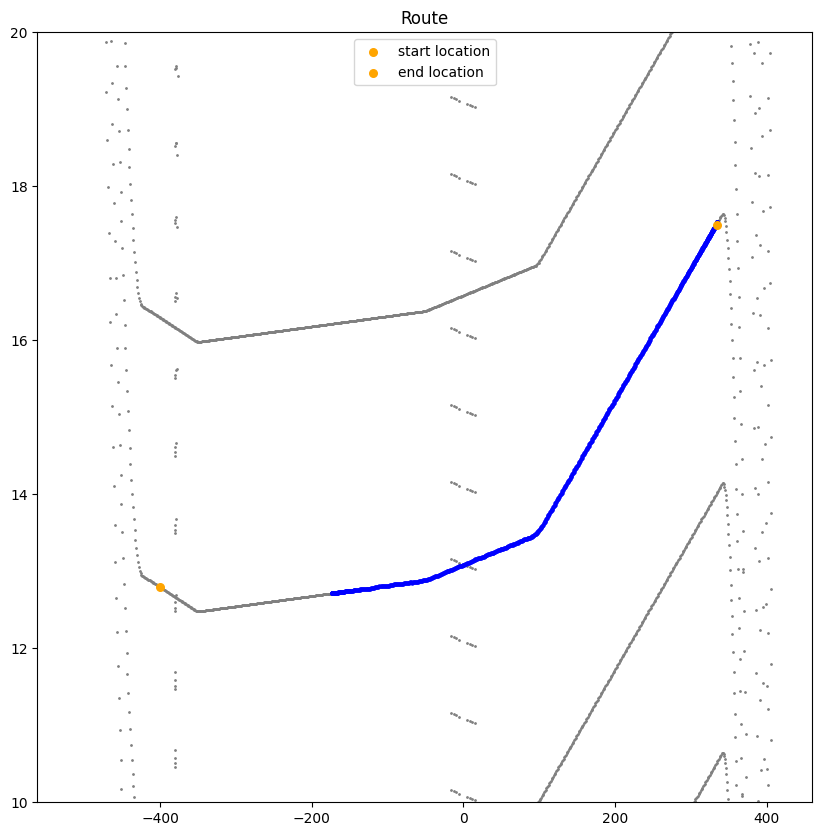

In [4]:
plt.figure(figsize=(10,10))
plt.scatter(map_locations[:,0], map_locations[:,1], s=1, c='gray')
plt.scatter(data[4]['ego_locations'][:,0], data[4]['ego_locations'][:,1], s=5, c='blue')

plt.scatter(335.1, 17.5, c='orange', s=30, label='start location')
plt.scatter(-400.0, 12.8, c='orange', s=30, label='end location')

plt.ylim(10, 20)

plt.title('Route')
plt.legend()
plt.show()

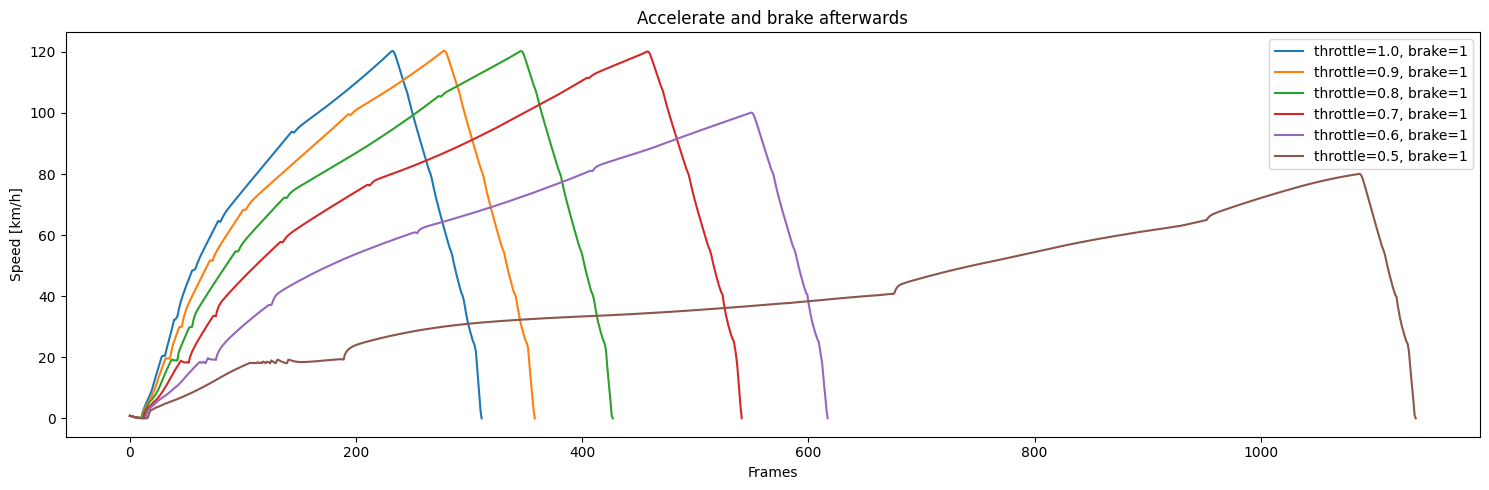

In [5]:
# x = np.arange(0, 800)
# y = 0.5633837*x/20
plt.figure(figsize= (15,5))

plt.title('Accelerate and brake afterwards')
[plt.plot(data[i]['ego_speeds'], label=f'throttle={1-i/10}, brake=1') for i in range(6)]
plt.legend()

plt.ylabel('Speed [km/h]')
plt.xlabel('Frames')
plt.tight_layout()
plt.savefig('acceleration_and_brake.png')

In [6]:
accelerate_dataset = np.empty((0, 3), dtype=np.float64)
brake_dataset =  np.empty((0, 2), dtype=np.float64)

for i, d in enumerate(data):
    ego_speeds = d['ego_speeds'][10:]
    argmax_idx = np.argmax(ego_speeds)
    last_idx = argmax_idx+np.argmax(ego_speeds[argmax_idx:]<1)
    acc_speeds, brake_speeds = ego_speeds[:argmax_idx], ego_speeds[argmax_idx:last_idx]
    
    throttles = np.repeat(d['throttle'], acc_speeds.shape[0]-1)
    acc_append = np.array([acc_speeds[:-1], throttles, acc_speeds[1:]]).T
    accelerate_dataset = np.concatenate([accelerate_dataset, acc_append], axis=0)
    
    brake_append = np.array([brake_speeds[:-1], brake_speeds[1:]]).T
    brake_dataset = np.concatenate([brake_dataset, brake_append], axis=0)

In [7]:
acc_inp = np.column_stack([accelerate_dataset[:,0],
                          accelerate_dataset[:,0]**2,
                          accelerate_dataset[:,1],
                          accelerate_dataset[:,1]**2,
                          accelerate_dataset[:,0] * accelerate_dataset[:,1],
                          accelerate_dataset[:,0] * accelerate_dataset[:,1]**2,
                          accelerate_dataset[:,0]**2 * accelerate_dataset[:,1],
                          accelerate_dataset[:,0]**2 * accelerate_dataset[:,1]**2])
acc_trg = accelerate_dataset[:, 2]

params_acceleration = np.linalg.lstsq(acc_inp, acc_trg, rcond=None)[0]
print(params_acceleration)

[ 9.66149739e-01  4.01962799e-04 -4.68642597e-01  1.82126771e+00
  8.88873927e-02 -6.95215099e-02 -9.92230087e-04  6.35372839e-04]


In [8]:
brake_inp = np.column_stack([brake_dataset[:,0]**1,
                              brake_dataset[:,0]**2,
                              brake_dataset[:,0]**3,
                              brake_dataset[:,0]**4,
                              brake_dataset[:,0]**5,
                              brake_dataset[:,0]**6,
                              brake_dataset[:,0]**7])
brake_trg = brake_dataset[:, 1]

params_brake = np.linalg.lstsq(brake_inp, brake_trg, rcond=None)[0]
print(params_brake)

[ 9.29344110e-03  8.22707909e-02 -2.85148764e-03  5.10288503e-05
 -4.95285659e-07  2.47562682e-09 -4.99124353e-12]


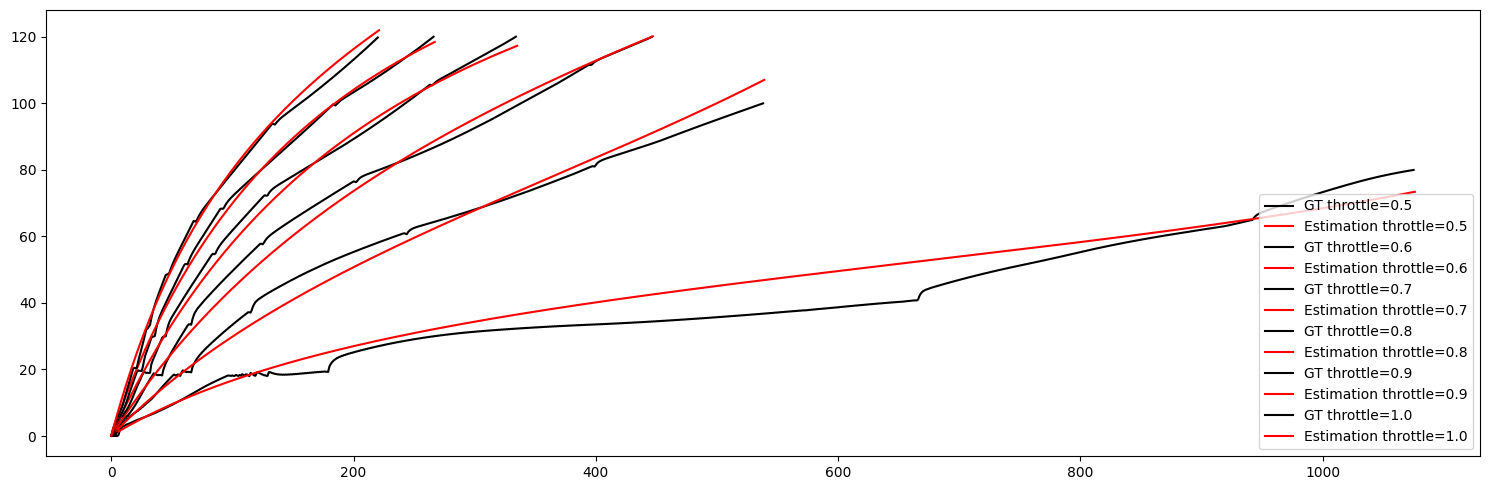

In [9]:
throttle = 1.0

def estimate_next_speed_acceleration(current_speed, throttle):
    features = np.array([current_speed, current_speed**2, throttle, throttle**2, current_speed * throttle, current_speed * throttle**2, current_speed**2 * throttle, current_speed**2 * throttle**2])
    
    return features @ params_acceleration

plt.figure(figsize= (15,5))
for throttle in [0.5, 0.6, 0.7, 0.8, 0.9, 1.0]:
    flag = accelerate_dataset[:,1] == throttle
    y = accelerate_dataset[flag, 0]
    plt.plot(y, label=f'GT throttle={throttle}', c='black')

    estimated_speed = [y[0]]
    current_speed = y[0]
    for i in range(len(y)):
        current_speed = estimate_next_speed_acceleration(current_speed, throttle)
        estimated_speed.append(current_speed)
    plt.plot(estimated_speed, label=f'Estimation throttle={throttle}', c='red')

plt.tight_layout()
plt.legend()
plt.show()

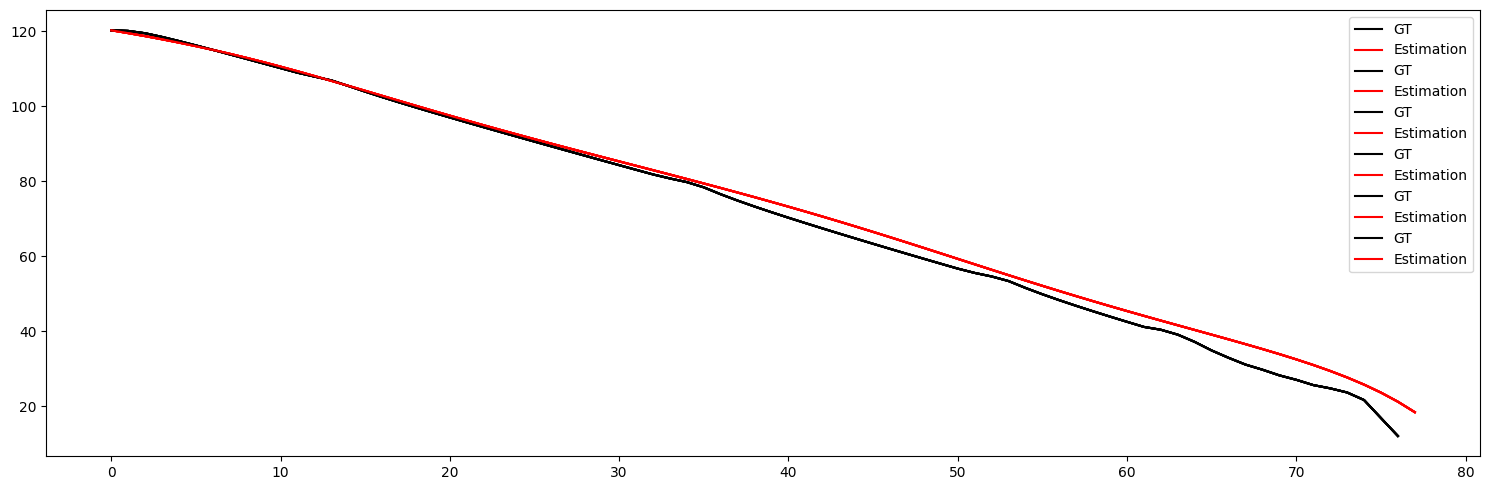

In [10]:
def estimate_next_speed_braking(current_speed):
    features = np.array([current_speed, current_speed**2, current_speed**3, current_speed**4, current_speed**5, current_speed**6, current_speed**7])
    
    return features @ params_brake

plt.figure(figsize= (15,5))
for throttle in [0.5, 0.6, 0.7, 0.8, 0.9, 1.0]:
    till = np.argmax(brake_dataset[:,0]<8)
    y = brake_dataset[:till, 0]
    plt.plot(y, label=f'GT', c='black')

    estimated_speed = [y[0]]
    current_speed = y[0]
    for i in range(len(y)):
        current_speed = estimate_next_speed_braking(current_speed)
        estimated_speed.append(current_speed)
    plt.plot(estimated_speed, label=f'Estimation', c='red')

plt.tight_layout()
plt.legend()
plt.show()